In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


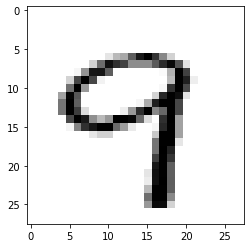

In [0]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))



dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)


# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

In [0]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
            
        ) # output_size = 24
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2)
         # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 11
        
        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
           
        ) # output_size = 9
        #self.pool2 = nn.MaxPool2d(2, 2)
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 7

        

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(16),
            #nn.ReLU(),
            #nn.Dropout(dropout_value)
       #) # output_size = 7

        #self.convblock8 = nn.Sequential(
            #nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        #x = self.pool1(x)
        #x = self.dropout(x)
        
        x = self.convblock4(x)
       
        x = self.convblock5(x)
        #x = self.pool2(x)
        x = self.convblock6(x)
        
        #x = self.dropout(x)
        x = self.gap(x) 
        x = self.convblock7(x)
        #x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           1,152
             ReLU-11           [-1, 16, 10, 10]               0
      BatchNorm2d-12           [-1, 16, 10, 10]              32
          Dropout-13           [-1, 16, 10, 10]               0
           Conv2d-14             [

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def find_misclassified(model,num_img=25):
   images = []
   targ_list = []
   pred_list = []
   count = 0
   with torch.no_grad():
     for data, target in test_loader:
       data, target = data.to(device), target.to(device)
       output = model(data)
       pred = output.argmax(dim =1,keepdim=True).view_as(target)
       for d, t, p in zip(data,target,pred):
         if t!=p:
           d=d.cpu().numpy()
           t=t.cpu().numpy()
           p=p.cpu().numpy()
           d=(d*0.3081)+0.1307
           images.append(d)
           targ_list.append(t)
           pred_list.append(p)
           count+=1
         if count==num_img:
           return images, targ_list, pred_list  


%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
def plot_misclssified(images,targ_list,pred_list,num_img=25,save = False):
  fig = plt.figure(figsize=(15,((num_img//5)+1)*3))
  for i in range(0,num_img):
    ax=fig.add_subplot((num_img//5)+1,5,i+1)
    ax.imshow(np.rollaxis(img[i],0,3).squeeze(),cmap='gray')
    ax.axis('off')
    ax.set_title("Actual: "+str(targ_list[i])+" Predicted: "+str(pred_list[i]))
  if save==True:
    plt.savefig('fig.png')
    plt.imshow()                 

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.03203094005584717 Batch_id=468 Accuracy=92.77: 100%|██████████| 469/469 [00:11<00:00, 39.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0749, Accuracy: 9767/10000 (97.67%)

EPOCH: 1


Loss=0.073123499751091 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:11<00:00, 40.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 9862/10000 (98.62%)

EPOCH: 2


Loss=0.024659788236021996 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:11<00:00, 40.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9888/10000 (98.88%)

EPOCH: 3


Loss=0.08776374906301498 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:11<00:00, 41.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9901/10000 (99.01%)

EPOCH: 4


Loss=0.03131083771586418 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:11<00:00, 40.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9908/10000 (99.08%)

EPOCH: 5


Loss=0.010474865324795246 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:11<00:00, 39.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9904/10000 (99.04%)

EPOCH: 6


Loss=0.006040707230567932 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:11<00:00, 40.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Accuracy: 9887/10000 (98.87%)

EPOCH: 7


Loss=0.010248283855617046 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:11<00:00, 41.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9918/10000 (99.18%)

EPOCH: 8


Loss=0.009208480827510357 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:11<00:00, 40.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.004589781165122986 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:11<00:00, 40.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9912/10000 (99.12%)

EPOCH: 10


Loss=0.057647958397865295 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:11<00:00, 40.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.006616706494241953 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:11<00:00, 40.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9927/10000 (99.27%)

EPOCH: 12


Loss=0.0013294318923726678 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:11<00:00, 40.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9935/10000 (99.35%)

EPOCH: 13


Loss=0.06008532643318176 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:11<00:00, 40.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9924/10000 (99.24%)

EPOCH: 14


Loss=0.04017385467886925 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:12<00:00, 38.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9929/10000 (99.29%)

EPOCH: 15


Loss=0.01905178464949131 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:11<00:00, 40.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9926/10000 (99.26%)

EPOCH: 16


Loss=0.0012434025993570685 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:11<00:00, 40.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9945/10000 (99.45%)

EPOCH: 17


Loss=0.006505399942398071 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 40.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9931/10000 (99.31%)

EPOCH: 18


Loss=0.005296985153108835 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:11<00:00, 40.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

EPOCH: 19


Loss=0.012261837720870972 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:11<00:00, 39.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9930/10000 (99.30%)

EPOCH: 20


Loss=0.0033629138488322496 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:11<00:00, 39.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9938/10000 (99.38%)

EPOCH: 21


Loss=0.06444662809371948 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:11<00:00, 40.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9945/10000 (99.45%)

EPOCH: 22


Loss=0.011762331239879131 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:11<00:00, 40.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9921/10000 (99.21%)

EPOCH: 23


Loss=0.048610951751470566 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:12<00:00, 38.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9928/10000 (99.28%)

EPOCH: 24


Loss=0.0013167262077331543 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:11<00:00, 40.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9941/10000 (99.41%)

EPOCH: 25


Loss=0.062480028718709946 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:11<00:00, 41.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9918/10000 (99.18%)

EPOCH: 26


Loss=0.00788569450378418 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 41.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9932/10000 (99.32%)

EPOCH: 27


Loss=0.034253329038619995 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:11<00:00, 41.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9935/10000 (99.35%)

EPOCH: 28


Loss=0.036466579884290695 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:11<00:00, 40.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9937/10000 (99.37%)

EPOCH: 29


Loss=0.02519630827009678 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:12<00:00, 36.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9937/10000 (99.37%)

EPOCH: 30


Loss=0.03433544561266899 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:11<00:00, 39.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9944/10000 (99.44%)

EPOCH: 31


Loss=0.00890427827835083 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:11<00:00, 39.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9940/10000 (99.40%)

EPOCH: 32


Loss=0.04711022600531578 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:12<00:00, 38.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9932/10000 (99.32%)

EPOCH: 33


Loss=0.0689118430018425 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:11<00:00, 45.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9929/10000 (99.29%)

EPOCH: 34


Loss=0.09853062033653259 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:11<00:00, 40.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9933/10000 (99.33%)

EPOCH: 35


Loss=0.004648914095014334 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:11<00:00, 40.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9928/10000 (99.28%)

EPOCH: 36


Loss=0.005758399609476328 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:11<00:00, 39.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9931/10000 (99.31%)

EPOCH: 37


Loss=0.03009425662457943 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:12<00:00, 37.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9938/10000 (99.38%)

EPOCH: 38


Loss=0.005385523196309805 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:12<00:00, 37.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9937/10000 (99.37%)

EPOCH: 39


Loss=0.0069656274281442165 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:12<00:00, 37.06it/s]



Test set: Average loss: 0.0180, Accuracy: 9945/10000 (99.45%)



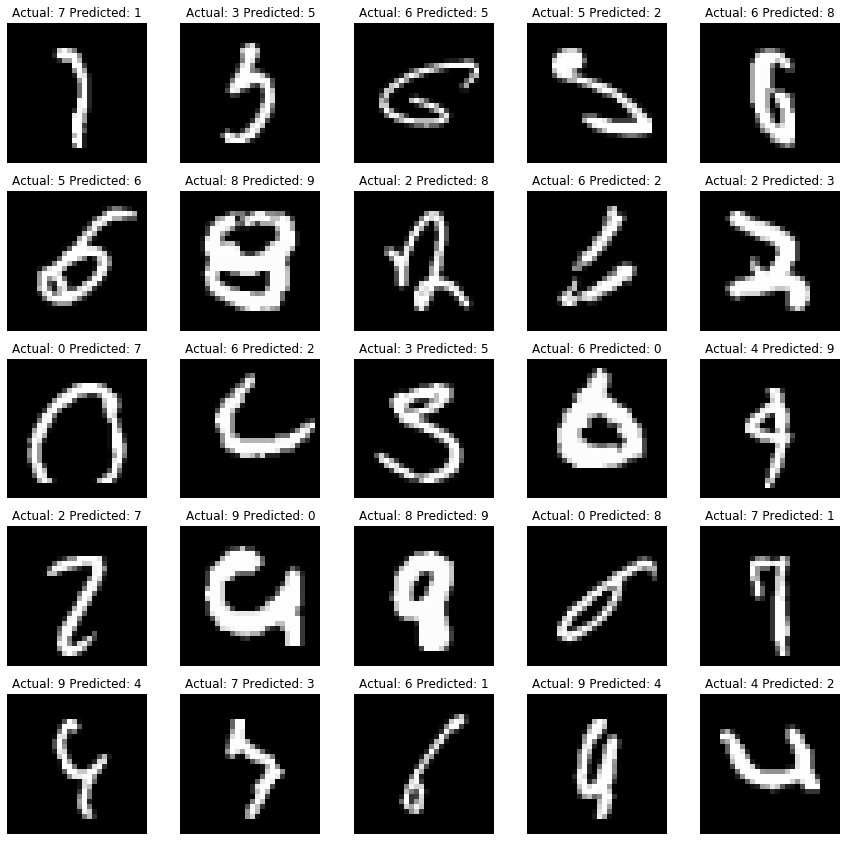

In [0]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, weight_decay = 0, momentum=0.9, dampening = 0, nesterov = False)
scheduler = StepLR(optimizer, step_size=4, gamma=0.5)

EPOCHS = 40

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

img, targ, pred = find_misclassified(model)
plot_misclssified(img, targ, pred)

Text(0.5, 1.0, 'Test Accuracy')

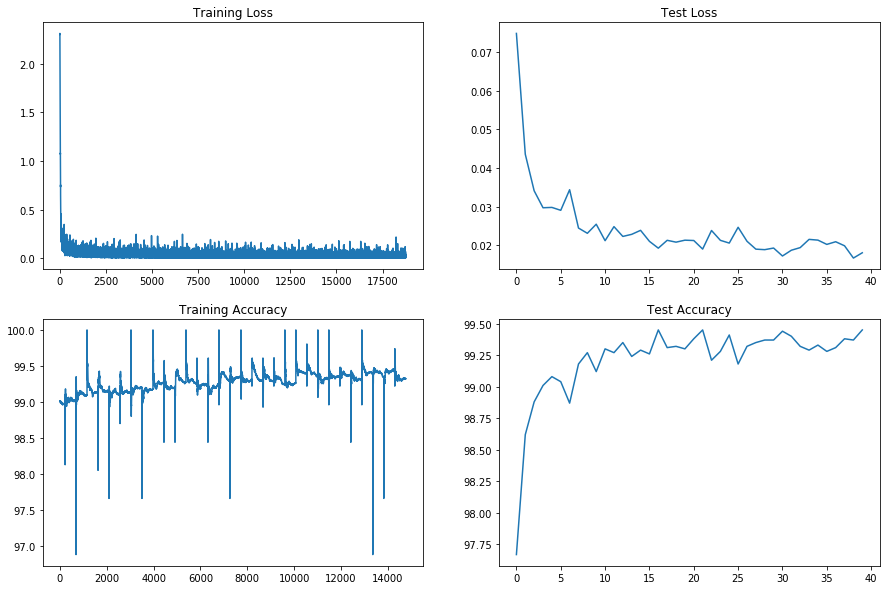

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")



Submitted by G Uday Kiran and V Srilakshmi